In [1]:
!pip install fiona
!pip install pyproj
!pip install rtree
!pip install shapely
!pip install pyogrio
!pip install packaging
!pip install numpy
!pip install geopandas
!pip install matplotlib
!pip install mapclassify
!pip install folium
!pip install haversine

In [40]:
from src.enum.identifiers.Ride import Ride
from src.enum.identifiers.Net import Net
from src.enum.setup.Paths import Paths
from src.enum.setup.Dataset import Dataset
from src.enum.setup.FileFormat import FileFormat
from src.enum.setup.FileName import FileName
from src.enum.setup.City import City
from src.utils import utils
import geopandas as gpd
import json
import os
from haversine import haversine, Unit
import itertools

In [41]:
input_absolute_path_to_file = utils.generate_absolute_path_to_file(
    Paths.TAZ,
    FileName.TAZ_BOUNDARY,
    FileFormat.GEOJSON,
    Dataset.UBER,
    City.SAN_FRANCISCO
)
gdf = gpd.read_file(input_absolute_path_to_file)

In [42]:
gdf[Net.AREA.value] = gdf.area
gdf[Net.BOUNDARY.value] = gdf.boundary
gdf[Net.CENTROIDS.value] = gdf.centroid

/var/folders/lk/f9788htd3zz7ym_g3009qc0w0000gn/T/ipykernel_61677/1657571606.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf[Net.AREA.value] = gdf.area
/var/folders/lk/f9788htd3zz7ym_g3009qc0w0000gn/T/ipykernel_61677/1657571606.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf[Net.CENTROIDS.value] = gdf.centroid


In [43]:
gdf.head()

,AREA,PERIMETER,TZ06_D00_,TZ06_D00_I,STATE,COUNTY,TAZ,NAME,LSAD,LSAD_TRANS,MOVEMENT_ID,DISPLAY_NAME,geometry,area,boundary,centroids
0,0.000073,0.047229,3372,3373,06,075,100281,100281,,,3370,100281 (3370),"POLYGON ((-122.41888 37.80803, -122.42028 37.8...",0.000073,"LINESTRING (-122.41888 37.80803, -122.42028 37...",POINT (-122.40975 37.80863)
1,0.000040,0.024635,3374,3375,06,075,100301,100301,,,3372,100301 (3372),"POLYGON ((-122.42607 37.81096, -122.42594 37.8...",0.000040,"LINESTRING (-122.42607 37.81096, -122.42594 37...",POINT (-122.42245 37.80809)
2,0.000056,0.043989,3377,3378,06,075,100324,100324,,,3375,100324 (3375),"POLYGON ((-122.42678 37.80963, -122.42668 37.8...",0.000056,"LINESTRING (-122.42678 37.80963, -122.42668 37...",POINT (-122.43580 37.80725)
3,0.000255,0.066106,3379,3380,06,075,100392,100392,,,3377,100392 (3377),"POLYGON ((-122.47719 37.81058, -122.47698 37.8...",0.000255,"LINESTRING (-122.47719 37.81058, -122.47698 37...",POINT (-122.47670 37.79657)
4,0.000102,0.073261,3384,3385,06,075,100393,100393,,,3382,100393 (3382),"POLYGON ((-122.47719 37.81058, -122.47034 37.8...",0.000102,"LINESTRING (-122.47719 37.81058, -122.47034 37...",POINT (-122.46305 37.80521)


In [44]:
gdf.shape

(731, 16)

In [45]:
gdf.explore(Net.AREA, legend=False)

<AxesSubplot:>

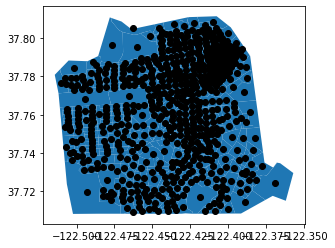

In [46]:
ax = gdf[Net.GEOMETRY.value].plot()
gdf[Net.CENTROIDS.value].plot(ax=ax, color="black")

In [47]:
polygon = gdf[Net.GEOMETRY.value].iloc[0]

def distance(p1,p2):
    return haversine((p1[1],p1[0]),(p2[1],p2[0]), unit=Unit.METERS)

def max_distance_from_centroid(polygon):
    max = 0
    for p1 in polygon.exterior.coords:
        p2 = polygon.centroid.coords[0]
        distance = distance(p1,p2)
        if distance > max:
            max = distance


In [48]:

rows_distances = []
for i in range(gdf.shape[0]):
    distances = []
    label = f"{gdf[Net.TAZ.value.upper()].iloc[i]}"
    centroid = gdf[Net.CENTROIDS.value].iloc[i]
    distances = gdf[Net.CENTROIDS.value].distance(centroid)
    for idx, distance in enumerate(distances):
        ref_zip_code = gdf[Net.TAZ.value.upper()].iloc[i]
        other_zip_code = gdf[Net.TAZ.value.upper()].iloc[idx]
        rows_distances.append((ref_zip_code, other_zip_code, distance))
    #gdf[label] = distances

gdf_distance = gpd.GeoDataFrame(rows_distances, columns=[Net.SOURCE.value, Net.DESTINATION.value, Net.DISTANCE.value])

/var/folders/lk/f9788htd3zz7ym_g3009qc0w0000gn/T/ipykernel_61677/1898975150.py:6: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  distances = gdf[Net.CENTROIDS.value].distance(centroid)


In [50]:
gdf.head(25)

,AREA,PERIMETER,TZ06_D00_,TZ06_D00_I,STATE,COUNTY,TAZ,NAME,LSAD,LSAD_TRANS,MOVEMENT_ID,DISPLAY_NAME,geometry,area,boundary,centroids
0,0.000073,0.047229,3372,3373,06,075,100281,100281,,,3370,100281 (3370),"POLYGON ((-122.41888 37.80803, -122.42028 37.8...",0.000073,"LINESTRING (-122.41888 37.80803, -122.42028 37...",POINT (-122.40975 37.80863)
1,0.000040,0.024635,3374,3375,06,075,100301,100301,,,3372,100301 (3372),"POLYGON ((-122.42607 37.81096, -122.42594 37.8...",0.000040,"LINESTRING (-122.42607 37.81096, -122.42594 37...",POINT (-122.42245 37.80809)
2,0.000056,0.043989,3377,3378,06,075,100324,100324,,,3375,100324 (3375),"POLYGON ((-122.42678 37.80963, -122.42668 37.8...",0.000056,"LINESTRING (-122.42678 37.80963, -122.42668 37...",POINT (-122.43580 37.80725)
3,0.000255,0.066106,3379,3380,06,075,100392,100392,,,3377,100392 (3377),"POLYGON ((-122.47719 37.81058, -122.47698 37.8...",0.000255,"LINESTRING (-122.47719 37.81058, -122.47698 37...",POINT (-122.47670 37.79657)
4,0.000102,0.073261,3384,3385,06,075,100393,100393,,,3382,100393 (3382),"POLYGON ((-122.47719 37.81058, -122.47034 37.8...",0.000102,"LINESTRING (-122.47719 37.81058, -122.47034 37...",POINT (-122.46305 37.80521)
5,0.000032,0.025371,3391,3392,06,075,100321,100321,,,3389,100321 (3389),"POLYGON ((-122.42678 37.80963, -122.42538 37.8...",0.000032,"LINESTRING (-122.42678 37.80963, -122.42538 37...",POINT (-122.42901 37.80625)
6,0.000018,0.018220,3396,3397,06,075,100284,100284,,,3394,100284 (3394),"POLYGON ((-122.41858 37.80613, -122.41888 37.8...",0.000018,"LINESTRING (-122.41858 37.80613, -122.41888 37...",POINT (-122.41530 37.80701)
7,0.000029,0.023382,3398,3399,06,075,100381,100381,,,3396,100381 (3396),"POLYGON ((-122.44841 37.80722, -122.44273 37.8...",0.000029,"LINESTRING (-122.44841 37.80722, -122.44273 37...",POINT (-122.44575 37.80514)
8,0.000046,0.027705,3408,3409,06,075,100261,100261,,,3406,100261 (3406),"POLYGON ((-122.39975 37.80664, -122.39814 37.8...",0.000046,"LINESTRING (-122.39975 37.80664, -122.39814 37...",POINT (-122.39971 37.80273)
9,0.000010,0.013024,3413,3414,06,075,100304,100304,,,3411,100304 (3411),"POLYGON ((-122.42168 37.80473, -122.42138 37.8...",0.000010,"LINESTRING (-122.42168 37.80473, -122.42138 37...",POINT (-122.42345 37.80409)


In [51]:
gdf[gdf[Net.TAZ.value.upper()]==1]

,AREA,PERIMETER,TZ06_D00_,TZ06_D00_I,STATE,COUNTY,TAZ,NAME,LSAD,LSAD_TRANS,MOVEMENT_ID,DISPLAY_NAME,geometry,area,boundary,centroids


In [52]:
gdf_distance.head()


,src,dst,distance
0,100281,100281,0.000000
1,100281,100301,0.012714
2,100281,100324,0.026092
3,100281,100392,0.068033
4,100281,100393,0.053415


In [53]:
gdf_distance.shape

(534361, 3)

In [54]:
gdf_distance[gdf_distance[Net.SOURCE.value]==1]

,src,dst,distance


In [55]:
gdf_distance_ordered = gdf_distance.sort_values(by=[Net.SOURCE.value, Net.DISTANCE.value])

In [56]:
gdf_distance_ordered.head()

,src,dst,distance
67344,100011,100011,0.000000
67364,100011,10001I,0.000836
67331,100011,100166,0.000887
67348,100011,100012,0.001225
67338,100011,100164,0.001420


In [57]:
def label_distance(row):
    if row[Net.DISTANCE.value] <= 0.030:
        return Ride.SHORT.value
    if row[Net.DISTANCE.value] <= 0.060:
        return Ride.NORMAL.value
    if row[Net.DISTANCE.value] <= 0.09:
        return Ride.LONG.value
    if row[Net.DISTANCE.value] > 0.09:
        return Ride.EXTREME.value

In [58]:
gdf_distance_ordered[Net.LENGTH.value] = gdf_distance_ordered.apply(lambda x: label_distance(x), axis=1)

In [59]:
gdf_distance_ordered[gdf_distance_ordered[Net.SOURCE.value]==1]

,src,dst,distance,length


In [ ]:
distance_dict = {}
for k, row in gdf_distance_ordered.iterrows():
    if not row[Net.SOURCE.value] in distance_dict:
        distance_dict[row[Net.SOURCE.value]] = {
            Ride.SHORT.value: [],
            Ride.NORMAL.value: [],
            Ride.LONG.value: [],
            Ride.EXTREME.value: []
        }
    distance_dict[row[Net.SOURCE.value]][row[Net.LENGTH.value]].append(str(row[Net.DESTINATION.value]))

In [44]:
output_absolute_path_to_file = utils.generate_absolute_path_to_file(
    Paths.CENTROIDS_TAZ,
    FileName.CENTROIDS,
    FileFormat.CSV,
    Dataset.UBER,
    City.SAN_FRANCISCO
)
utils.check_path_exists(output_absolute_path_to_file, is_path_file=True)
gdf_distance_ordered.to_csv(output_absolute_path_to_file, index=False)

In [45]:
output_absolute_path_to_file = utils.generate_absolute_path_to_file(
    Paths.CENTROIDS_TAZ,
    FileName.CENTROIDS,
    FileFormat.JSON,
    Dataset.UBER,
    City.SAN_FRANCISCO
)
utils.check_path_exists(output_absolute_path_to_file, is_path_file=True)
utils.export_file_from_absolute_path(output_absolute_path_to_file, FileFormat.JSON, distance_dict)